In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir( os.path.join('..', 'notebook_format') )
from formats import load_style
load_style()

In [2]:
os.chdir(path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
%matplotlib inline
%load_ext watermark
%load_ext autoreload 
%autoreload 2

from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,scikit-learn,scipy

Ethen 2017-01-01 19:42:16 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.3
pandas 0.18.1
matplotlib 1.5.1
scikit-learn 0.18
scipy 0.18.1


# K-means

Clustering algorthims are a typical example of unsupervised clustering. Its task is to gathering similar samples (we'll need to define which similarity or distance (dissimilarity) measure we want to use) into groups based on the data attributes (features) alone. Let's start by creating a simple, 2-dimensional, synthetic dataset.

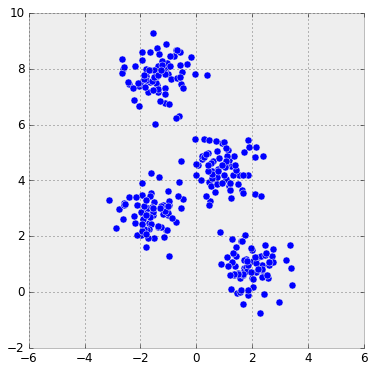

In [3]:
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter( X[:, 0], X[:, 1], s = 50 )
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

In the scatter plot above, we can see 4 separate groups of data points and we would like to recover them using clustering -- think of "discovering" the class labels that we've taken for granted in a classification task. Even though the groups are pretty obvious here, it becomes hard to find them when the data lives in a high-dimensional space, where we simply can't visualize them in a single scatterplot.

Now we will use one of the simplest clustering algorithms, **K-means**. This is an iterative algorithm which searches for 4 cluster centroids (we need to specify the number of clusters before we run the algorithm) such that the distance from each point to its cluster is minimized. 

It starts by choosing an initial set of centroids $\mu_j$ (in our case $j$ will count up to 4, since we want to have 4 clusters). A common practice is to choose randomly from the data points. After initialization, the K-means algorithm iterates between the following two steps:

1. Assign each data point $\mathbf{x}_i$ to the closest centroid $z_i$ using standard euclidean distance.

$$
z_i \gets \mathrm{argmin}_j \| \mathbf{x}_i - \mu_j \|_2
$$

2. Revise each centroids as the mean of the assigned data points.

$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

Where $n_j$ is the number of data points that belongs to cluster $j$.

One sidenote, the standard implementation of K-means uses the euclidean distance, thus we need to make sure all our variables are measured on the same scale if we are working with real-world datastets. Or else our distance measure will get dominated by features that have a large scale, leading to unexpected results.

Let's now implement a vanilla K-means algorithm.

In [4]:
def kmeans(X, k, maxiter, seed = None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    n_row, n_col = X.shape

    # randomly choose k data points as initial centroids
    if seed is not None:
        np.random.seed(seed)
    
    rand_indices = np.random.choice(n_row, size = k)
    centroids = X[rand_indices]

    for itr in range(maxiter):
        # compute distances between each data point and the set of centroids
        # and assign each data point to the closest centroid
        distances_to_centroids = pairwise_distances(X, centroids, metric = 'euclidean')
        cluster_assignment = np.argmin(distances_to_centroids, axis = 1)

        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([ X[cluster_assignment == i].mean(axis = 0) for i in range(k) ])
        
        # if the updated centroid is still the same,
        # then the algorithm converged
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return centroids, cluster_assignment

In [5]:
k = 4
centers, label = kmeans(X, k, maxiter = 100)

# we can count occurrences of each cluster label
np.bincount(label)

array([ 76,  31, 149,  44])

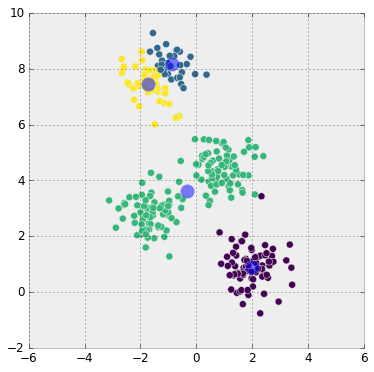

In [6]:
# plot the cluster and cluster's centroid
plt.scatter( X[:, 0], X[:, 1], s = 50, c = label, cmap = 'viridis' )
plt.scatter( centers[:, 0], centers[:, 1], s = 200, alpha = 0.5 )
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye! We can also use the pre-implemented `Kmeans` from scikit-learn to confirm the outputs.

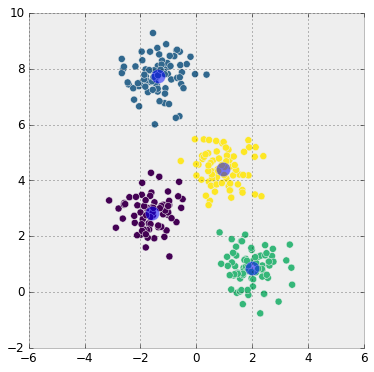

In [7]:
km = KMeans( n_clusters = 4 )
kmeans_y = km.fit_predict(X)
kmeans_centers = km.cluster_centers_

plt.scatter( X[:, 0], X[:, 1], s = 50, c = kmeans_y, cmap = 'viridis' )
plt.scatter( kmeans_centers[:, 0], kmeans_centers[:, 1], s = 200, alpha = 0.5 )
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

## Assessing Convergence

One weakness of K-means is, the algorithm's performance is closely tied with the randomly generated initial centroids' quality. If the algorithm starts with a set of bad inital centers, it will get stuck in a local minimum.

Before we get into that, we need to take a step back and ask ourselves how can we tell if the K-means algorithm is converging? Well, we can look at the cluster assignments and see if they stabilize over time. In fact, that's what we did in the toy implementation above, we ran the algorithm until the cluster assignments stop changing at all. But after running the clustering algorithm we want to have a measure that assesses the algorithm's performance. Hence, we'll introduce an additional measurement, **Total within Sum of Squares** (or refered to as inertia or heterogeneity). Mathematically, this is defined as:

$$ \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|_2^2 $$

Where $k$ denotes the total number of clusters, $x_i$ is the $i_{th}$ data point, $\mu_j$ is the $j_{th}$ cluster, and $\|\mathbf{x}_i - \mu_j\|_2^2$ denotes the squared L2 norm (Euclidean distance) between the two vectors.

The formula computes the sum of all squared distances between data points and its centroids. It computation can be divided into two small parts. The within sum of squares for a single cluster, $\sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|_2^2$ is the squared distance (note that it is "squared" distance!, do not square root it like we usually do for euclidean distance) of each point in the cluster from that cluster’s centroid. And the total within sum of squares, $\sum_{j=1}^k$, is the sum of the within sum of squares of all the clusters.

> It might be a bit confusing, as to why, in the objective function we're using, $\|\mathbf{x}_i - \mu_j\|_2^2$, the squared L2 norm (euclidean distance) between the two vectors, while earlier in the cluster assignment section, we use $z_i \gets \mathrm{argmin}_j \| \mathbf{x}_i - \mu_j \|_2$, the euclidean distance (without squaring it). The fact that we can use still use euclidean distance (without squaring) it to assign data points to its closest cluster centers is because squaring or not squaring the distance doesn’t affect the order, and it saves us a computation to square it back to squared euclidean distance.

To see that the convergence of this algorithm is not guaranteed, we'll add the new code to our original `kmeans` function to compute the heterogeneity. After that we'll run K-means multiple times. Each time, we use a different random seed to get different set of initial centroids.

In [8]:
def kmeans(X, k, maxiter, seed = None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    n_row, n_col = X.shape

    # randomly choose k data points as initial centroids
    if seed is not None:
        np.random.seed(seed)
    
    rand_indices = np.random.choice(n_row, size = k)
    centroids = X[rand_indices]

    for itr in range(maxiter):
        # compute distances between each data point and the set of centroids
        # and assign each data point to the closest centroid
        distances_to_centroids = pairwise_distances(X, centroids, metric = 'euclidean')
        cluster_assignment = np.argmin(distances_to_centroids, axis = 1)

        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([ X[cluster_assignment == i].mean(axis = 0) for i in range(k) ])
        
        # if the updated centroid is still the same,
        # then the algorithm converged
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    heterogeneity = 0
    for i in range(k):
        # note that pairwise_distance only accepts 2d-array
        cluster_data = X[cluster_assignment == i]
        distances = pairwise_distances( cluster_data, [centroids[i]], metric = 'euclidean' )
        heterogeneity += np.sum(distances ** 2)
    
    return centroids, cluster_assignment, heterogeneity

In [9]:
heterogeneity_kmeans = {}

for seed in [0, 1000, 8181, 555, 10000, 120000]:
    _, _, heterogeneity = kmeans(X, k, maxiter = 100, seed = seed)
    heterogeneity_kmeans[seed] = heterogeneity
    print( 'seed = {}, heterogeneity = {}'.format( seed, heterogeneity_kmeans[seed] ) )

seed = 0, heterogeneity = 212.00599621083518
seed = 1000, heterogeneity = 212.00599621083518
seed = 8181, heterogeneity = 523.7150139149792
seed = 555, heterogeneity = 528.0315740282444
seed = 10000, heterogeneity = 212.00599621083518
seed = 120000, heterogeneity = 528.5562600476272


Notice the variation in heterogeneity for different initializations. This shows K-means does in fact get stuck at a bad local minimum from time to time. So, the next question is, is there anything we can do about this?


## K-means++

One effective way to counter this issue is to use **K-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and lower average runtime (link to the original paper if you're interested in the theoretical guarantee [K-means++: The Advantages of Careful Seeding](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)). 

The workflow of K-means++ is as follows:

1. Choose a data point at random from the dataset, this serves as the first centroid
2. Compute the **squared** euclidean distance of all other data points to the randomly chosen first centroid
3. To generate the next centroid, each data point is chosen with the probability (weight) of its squared distance to the chosen center of this round divided by the the total squared distance (to make sure the probability adds up to 1). Roughtly speaking, a new centroid should be as far as from the other centroids as possible
4. Next, recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the second iteration, compare the data point's distance between the first and second center and choose the smaller one)
5. Repeat step 3 and 4 until we have $K$ centers

We'll now add the functionality of using K-means++ to initialize the initial cluster centroid to our original `kmeans` function.

In [10]:
def kmeans(X, k, init, maxiter, seed = None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """
    n_row, n_col = X.shape

    if seed is not None:
        np.random.seed(seed)
        
    if init == 'kmeanspp':
        # randomly choose the first centroid
        centroids  = np.zeros(( k, n_col ))
        rand_index = np.random.choice(n_row)
        centroids[0] = X[rand_index]
        
        # compute distances from the first centroid chosen to all the other data points
        distances = pairwise_distances( X, [centroids[0]], metric = 'euclidean' ).flatten()
    
        for i in range(1, k):
            # choose the next centroid, the probability for each data point to be chosen
            # is directly proportional to its squared distance from the nearest centroid
            prob = distances ** 2
            rand_index = np.random.choice(n_row, size = 1, p = prob / np.sum(prob))
            centroids[i] = X[rand_index]
            
            if i == k - 1:
                break
            
            # if we still need another cluster,
            # compute distances from the centroids to all data points
            # and update the squared distance as the minimum distance to all centroid
            distances_new = pairwise_distances( X, [centroids[i]], metric = 'euclidean' ).flatten()        
            distances = np.min( np.vstack(( distances, distances_new )), axis = 0 )
        
    else: # random
        rand_indices = np.random.choice(n_row, size = k)
        centroids = X[rand_indices]

    for itr in range(maxiter):
        # compute distances between each data point and the set of centroids
        # and assign each data point to the closest centroid
        distances_to_centroids = pairwise_distances(X, centroids, metric = 'euclidean')
        cluster_assignment = np.argmin(distances_to_centroids, axis = 1)

        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = np.array([ X[cluster_assignment == i].mean(axis = 0) for i in range(k) ])
        
        # if the updated centroid is still the same,
        # then the algorithm converged
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    heterogeneity = 0
    for i in range(k):
        # note that pairwise_distance only accepts 2d-array
        cluster_data = X[cluster_assignment == i]
        distances = pairwise_distances( cluster_data, [centroids[i]], metric = 'euclidean' )
        heterogeneity += np.sum(distances ** 2)
    
    return centroids, cluster_assignment, heterogeneity

Let's now rerun K-means using the same set of seeds as before, but this time we will always using K-means++ to initialize the centroid. Then, we'll compare the set of cluster heterogeneities we got from using K-means++ initialization versus using random initialization.

In [11]:
heterogeneity_kmeanspp = {}

for seed in [0, 1000, 8181, 555, 10000, 120000]:
    _, _, heterogeneity = kmeans(X, k, init = 'kmeanspp', maxiter = 100, seed = seed)
    heterogeneity_kmeanspp[seed] = heterogeneity
    print( 'seed = {}, heterogeneity = {}'.format(seed, heterogeneity_kmeanspp[seed]) )

print()
print( 'kmeans average: {}'.format( np.mean( list(heterogeneity_kmeans.values()) ) ) )    
print( 'kmeans++ average: {}'.format( np.mean( list(heterogeneity_kmeanspp.values()) ) ) )

seed = 0, heterogeneity = 212.00599621083518
seed = 1000, heterogeneity = 212.00599621083518
seed = 8181, heterogeneity = 212.00599621083518
seed = 555, heterogeneity = 212.00599621083518
seed = 10000, heterogeneity = 212.00599621083518
seed = 120000, heterogeneity = 212.00599621083518

kmeans average: 369.38680610389275
kmeans++ average: 212.0059962108352


From the result, we can see that random initialization results in a worse clustering heterogeneity than K-means++ on average. 

Although it looks like K-means++ worked pretty well in this simple example, it is not a panacea. It can still get stuck at local minima from time to time. Thus, in practice, we should run K-means at least a few times with different initializations and then return the best one (one that resulted in the lowest heterogeneity). For scikit-learn's [Kmeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), the default behavior is to run the algorithm for 10 times (`n_init` parameter) using the kmeans++ (`init` parameter) initialization.

## Elbow Method for Choosing K

Another "short-comings" of K-means is that we have to specify the number of clusters before running the algorithm, which we often don't know apriori. For example, let's have a look what happens if we set the number of clusters to 3 in our synthetic dataset.

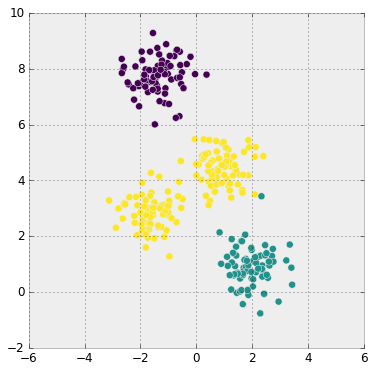

In [12]:
km = KMeans(n_clusters = 3, random_state = 42)
labels = km.fit_predict(X)

plt.scatter( X[:, 0], X[:, 1], s = 50, c = labels, cmap = 'viridis' )
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

K-means can still run perfectly fine, but this the probably not the result we're looking for.

There're many different heuristics for choosing the suitable $K$, the simplest one being the **Elbow method**. The way it works is we run the algorithm using different values of $K$ and plot the heterogeneity. This measure will decrease as the number of clusters increases, because each cluster will be smaller and tighter. And what we’re hoping for is the measure will keep on decreasing up till the optimal cluster number, and the decrease will start to flat out after that.

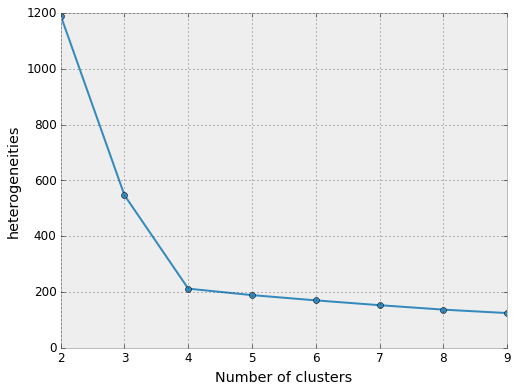

In [13]:
heterogeneities = []
for i in range(2, 10):
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(X)
    heterogeneities.append(km.inertia_)

plt.plot( range(2, 10), heterogeneities, marker = 'o' )
plt.xlabel('Number of clusters')
plt.ylabel('heterogeneities')
plt.show()

As we can see, the plot suggests we should choose 4 as our cluster number, since starting from $K=4$ the magnitude of the decease starts dropping (it looks like the pit of an elbow, that's why it was given the name the elbow method), which makes sense given our visual expection of the dataset previously. In practice, this "elbow" can sometimes be hard to see and can be quite subjective.

Now that we gotten a bit familiar with how K-means works, we'll start addressing the assumption that K-means is making and its caveats.


## Kmeans Caveats

Different algorithm makes different assumptions, hence the quality and interpretability of the result will depend on whether these assumptions are valid for our goal. For K-means clustering, the model assumes that **all clusters have equal, spherical variance**. To let the notion sink in, let's look at some cases where K-means will generate results that might not match our intuition.

Suppose our data looks like the following:

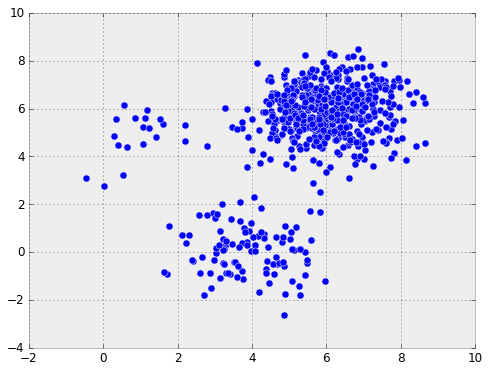

In [14]:
sizes = 20, 100, 500
sizes_cumsum = 0, 20, 120, 620
x_mean = 1, 4, 6
y_mean = 5, 0, 6

shape = np.sum(sizes), 2
coordinates = np.zeros(shape)

for idx, (s, xm, ym) in enumerate( zip(sizes, x_mean, y_mean) ):
    x = norm(xm).rvs(size = s)
    y = norm(ym).rvs(size = s)
    plt.scatter(x, y, s = 50)
    
    coord = np.vstack(( x, y )).T
    index = slice( sizes_cumsum[idx], sizes_cumsum[idx + 1] )
    coordinates[index] = coord

Here we randomly generated three cluster of data points drawn from three different normal distribution, each having 20, 100 and 500 data points. Let’s try K-means on this dataset.

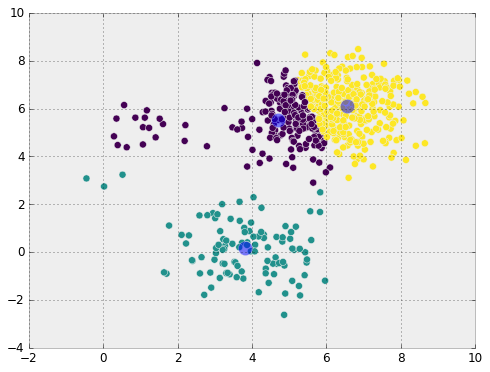

In [15]:
km = KMeans(n_clusters = 3, random_state = 42)
labels = km.fit_predict(coordinates)
centers = km.cluster_centers_

plt.scatter( coordinates[:, 0], coordinates[:, 1], s = 50, c = labels, cmap = 'viridis' )
plt.scatter( centers[:, 0], centers[:, 1], s = 200, alpha = 0.5 )
plt.show()

Ouch. In its quest to minimize the within-cluster sum of squares, K-means algorithm will give more "weight" to larger clusters. As we can see from the plot, a lot of data points from the smaller cluster (of size 20) end up being far away from any centroid, while the larger cluster (of size 500) gets chopped in half. This is because K-means assumes **all clusters have equal, spherical variance**, meaning that each cluster has roughly equal number of observations and the cluster's will tend to form a sphere shape.

Let's fit a different kind of clustering algorithm, Gaussian Mixture Model and visualize its clustering result:

True


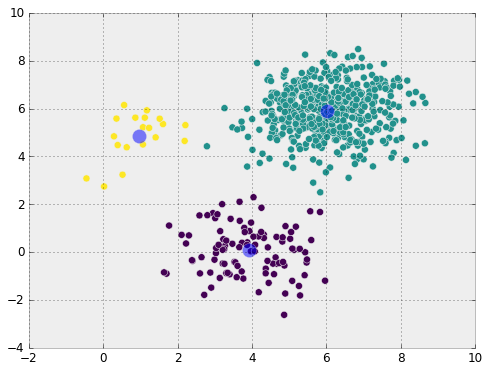

In [16]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components = 3, random_state = 42)
gmm.fit(coordinates)
print(gmm.converged_)

labels = gmm.predict(coordinates)
centers = gmm.means_

plt.scatter( coordinates[:, 0], coordinates[:, 1], s = 50, c = labels, cmap = 'viridis' )
plt.scatter( centers[:, 0], centers[:, 1], s = 200, alpha = 0.5 )
plt.show()

In general, there is no guarantee that structure found by a clustering algorithm has anything to do with what we were interested in. And there will always be edge cases where a clustering algorithm might lead to unintuitive results (for higher dimensions where we can't visualize the dataset easily, we might not even know whether the result matches our intuition or not). For visualization of comparing different clustering algorithms on toy 2d datasets, refer to the following link, [scikit-learn doc: Plot cluster comparison](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html).

The take away message for this section is that: K-means is usually "go-to" clustering algorithm for many, because it is fast, easy to understand, and available in lots of statistical or machine learning toolkit. If we have an EXTREMELY LARGE dataset then K-means might be our only option. But we must also understand that it is still making some assumptions and sometimes these assumptions can lead to unsatisfying or misleading results.

## Reference

- [Coursera: Washington Clustering & Retrieval](https://www.coursera.org/learn/ml-clustering-and-retrieval)
- [Notebook: K-Means In-Depth](https://github.com/jakevdp/sklearn_pycon2015/blob/master/notebooks/04.2-Clustering-KMeans.ipynb)
- [Notebook: Unsupervised Learning Part 2 -- Clustering](https://github.com/amueller/scipy-2016-sklearn/blob/master/notebooks/08%20Unsupervised%20Learning%20-%20Clustering.ipynb)
- [Blog: K-means clustering is not a free lunch](http://varianceexplained.org/r/kmeans-free-lunch/)
- [Blog: Improved Seeding For Clustering With K-Means++](https://datasciencelab.wordpress.com/2014/01/15/improved-seeding-for-clustering-with-k-means/)